In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random
from torch.utils.data import random_split
from torch.nn.modules.activation import Softmax
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
root = '.../CIS Final Project/data/'
os.chdir(root)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Convert images to tensors and add labels

real_cats_dir = os.path.join(root, 'real')
generated_cats_dir = os.path.join(root, 'generated_')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0,0,0],
                         std= [0.5,0.5,0.5])
])

def get_images(dir, label):
    images = []
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        if os.path.isfile(f):
            img = Image.open(f)
            images.append((transform(img), label))
    return images

# label 0 indicates real image
real_images = get_images(real_cats_dir, 0)
# label 1 indicates AI image
generated_images = get_images(generated_cats_dir, 1)

# Combine real and generated for full dataset
full_dataset = real_images + generated_images
random.shuffle(full_dataset)

In [ ]:
# Split into training and testing sets
train_size = int(0.8 * len(full_dataset))
test_size = int((len(full_dataset) - train_size)*.1)
val_size = len(full_dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(full_dataset, [train_size, test_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

images, labels = iter(train_loader).next()

torch.Size([32, 3, 256, 256])


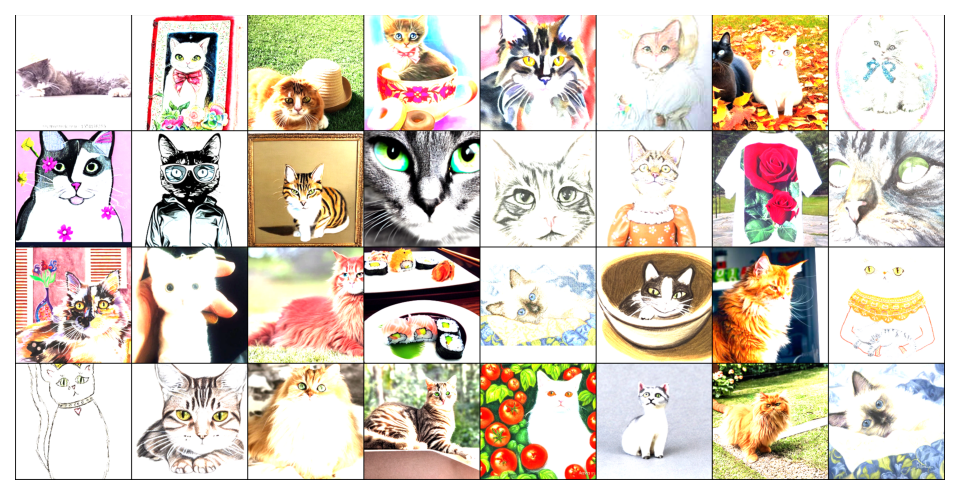

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

def imshow(img):
    img = img 
    npimg = img.numpy()
    figure(num=None, figsize=(8, 6), dpi=150, edgecolor='k')
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
      
        self.conv1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2,stride = 2, padding = 1) 
        )
        
        self.conv2 = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1) 
        )

        self.conv3 = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1) 
        )

        self.flatten = torch.nn.Flatten()
        
        self.fc1 = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(69696, 1028),
          nn.ReLU()
        ) 

        self.fc2 = nn.Sequential(
          nn.Dropout(0.2),
          nn.Linear(1028, 2)
        ) 
        
    def forward(self, x):
        x = self.conv1(x)  
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

net = Net()
net = net.to(device)

In [ ]:
epochs = 128
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= 0.001, weight_decay = 0.003)
loss_ = []
val_loss_ = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0
    val_running_loss = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)      
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    if (epoch+1) % 4 == 0:
      
      with torch.no_grad():
        correct = 0
        total = 0
        for i, data in enumerate(val_loader, 0):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          outputs = net(inputs)
          val_loss = criterion(outputs, labels)
          val_running_loss += val_loss.item()

          _, predicted = torch.max(outputs.data, 1)
          correct += predicted.eq(labels.reshape(len(labels),)).sum() 
          total += float(len(labels))
      
      accuracy = correct / total

      print(f'Epoch: {epoch+1}, Loss: {running_loss:.4f}, Validation Loss: {val_running_loss:.4f}, Validation Acc.: {accuracy:.4f}')
      loss_.append(running_loss)
      val_loss_.append(val_running_loss)

print('Finished Training')

Epoch: 4, Loss: 128.5319, Validation Loss: 3.2506, Validation Acc.: 0.8235
Epoch: 8, Loss: 116.1421, Validation Loss: 2.7719, Validation Acc.: 0.8487
Epoch: 12, Loss: 100.3565, Validation Loss: 2.2060, Validation Acc.: 0.8697
Epoch: 16, Loss: 82.9197, Validation Loss: 2.1367, Validation Acc.: 0.9118
Epoch: 20, Loss: 73.6690, Validation Loss: 1.8433, Validation Acc.: 0.8950
Epoch: 24, Loss: 66.9608, Validation Loss: 1.7203, Validation Acc.: 0.9202
Epoch: 28, Loss: 60.9077, Validation Loss: 2.4005, Validation Acc.: 0.8739
Epoch: 32, Loss: 54.3274, Validation Loss: 1.4681, Validation Acc.: 0.9286
Epoch: 36, Loss: 50.3654, Validation Loss: 2.1482, Validation Acc.: 0.9076
Epoch: 40, Loss: 50.7497, Validation Loss: 1.2764, Validation Acc.: 0.9244
Epoch: 44, Loss: 47.3426, Validation Loss: 2.5199, Validation Acc.: 0.8655
Epoch: 48, Loss: 44.6133, Validation Loss: 1.6822, Validation Acc.: 0.9244
Epoch: 52, Loss: 39.1718, Validation Loss: 2.2449, Validation Acc.: 0.9076
Epoch: 56, Loss: 38.6686

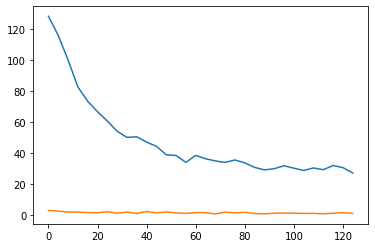

In [ ]:
x = [i for i in range(0,128,4)]
plt.plot(x, loss_)
plt.plot(x, val_loss_)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels.reshape(len(labels),)).sum() 
        total += float(len(labels))
    accuracy = correct / total

    print(f'Accuracy of Neural Network is {accuracy:.4f}')

Accuracy of Neural Network is 0.9370


In [ ]:
torch.save(net.state_dict(), '.../CIS Final Project/cnn.pth')

# Integrated Gradients
https://captum.ai/tutorials/Resnet_TorchVision_Interpret

In [ ]:
model_path = '.../CIS Final Project/cnn.pth'

#torch.cuda.memory_summary(device=device, abbreviated=False)
# Model class must be defined somewhere
net = Net()
net.load_state_dict(torch.load(model_path))
net.eval()
net.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(i

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
def get_attr_maps(img_indx):
  dataiter = iter(test_loader)
  images, labels = dataiter.next()

  input = images[img_indx:img_indx+1].to(device)

  output = net(input)
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, 1)

  # 0 = real
  # 1 = generated

  integrated_gradients = IntegratedGradients(net)
  attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

  img = input.cpu().numpy()[0]
  img = img / 2 - 0.025     # unnormalize

  plt.tight_layout()
  figure(figsize=(4.75, 4.75), dpi=80)
  plt.imshow(np.transpose(img, (1, 2, 0)))

  _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             show_colorbar=True,
                             sign='all')

  print('Predicted:', pred_label_idx.item(), '(', prediction_score.squeeze().item(), ')', '\nActual:', labels[img_indx:img_indx+1].item())

<Figure size 432x288 with 0 Axes>

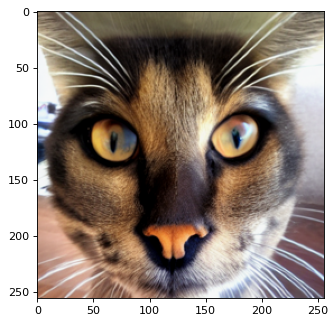

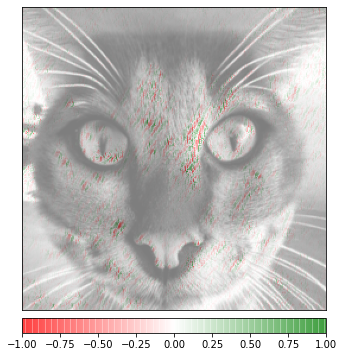

Predicted: 0 ( 0.966680645942688 ) 
Actual: 1


<Figure size 432x288 with 0 Axes>

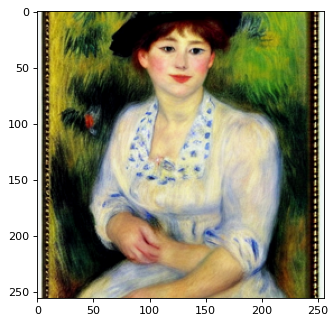

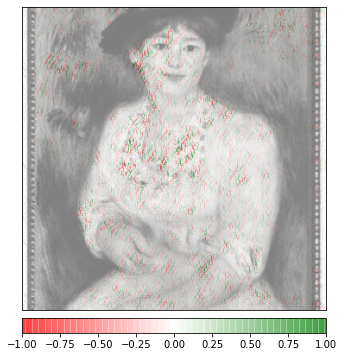

Predicted: 0 ( 0.9895920753479004 ) 
Actual: 1


<Figure size 432x288 with 0 Axes>

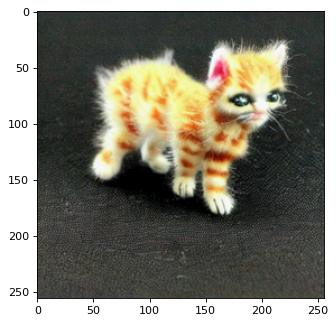

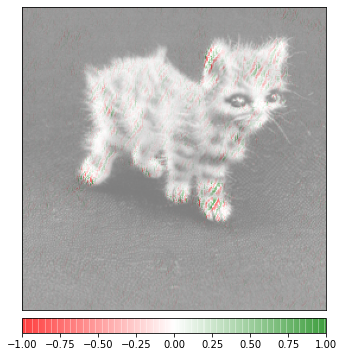

Predicted: 1 ( 0.8159034848213196 ) 
Actual: 1


<Figure size 432x288 with 0 Axes>

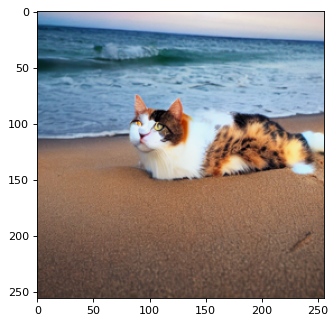

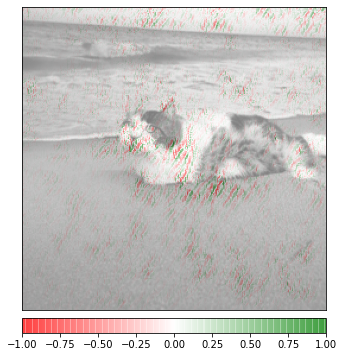

Predicted: 0 ( 0.8007290959358215 ) 
Actual: 1


<Figure size 432x288 with 0 Axes>

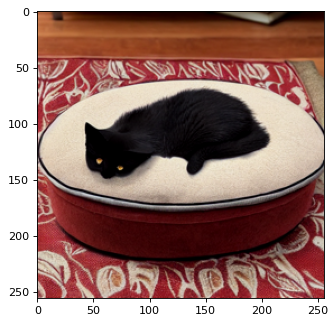

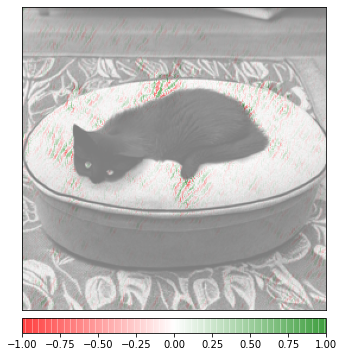

Predicted: 1 ( 0.8371217846870422 ) 
Actual: 1


<Figure size 432x288 with 0 Axes>

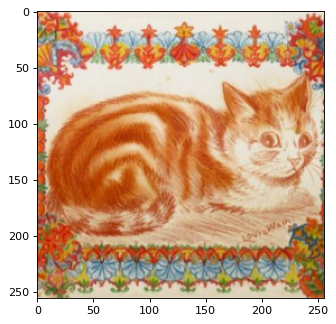

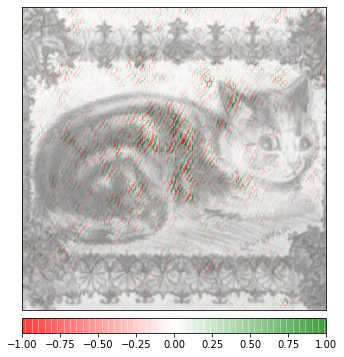

Predicted: 0 ( 0.99986732006073 ) 
Actual: 0


<Figure size 432x288 with 0 Axes>

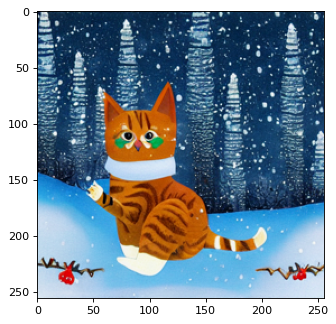

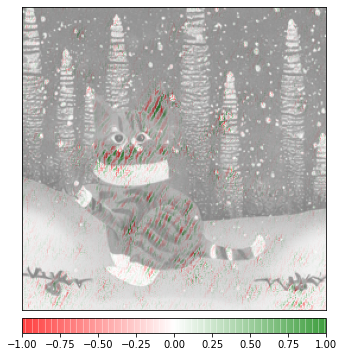

Predicted: 0 ( 0.9136059880256653 ) 
Actual: 1


<Figure size 432x288 with 0 Axes>

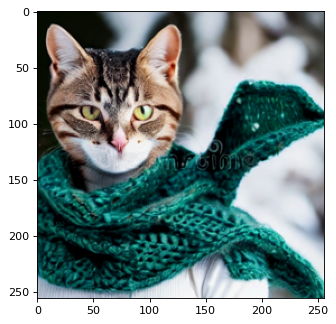

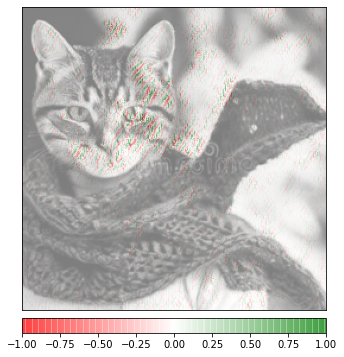

Predicted: 1 ( 0.5596705079078674 ) 
Actual: 1


<Figure size 432x288 with 0 Axes>

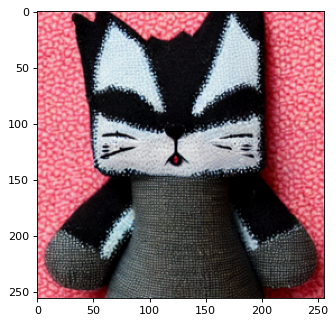

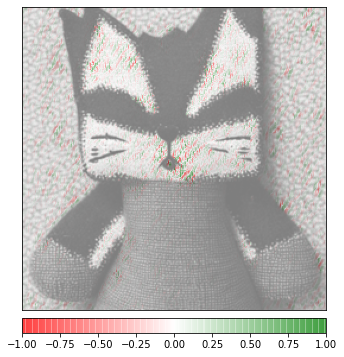

Predicted: 1 ( 0.6384987235069275 ) 
Actual: 1


<Figure size 432x288 with 0 Axes>

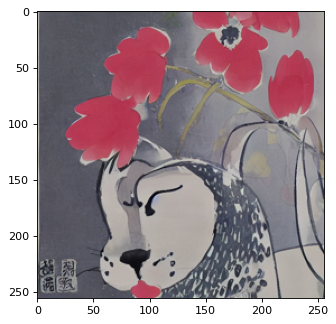

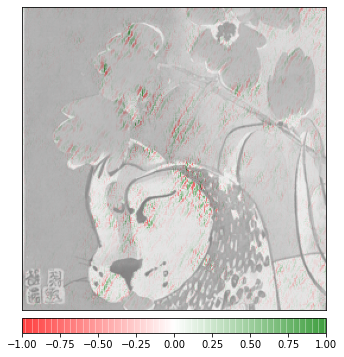

Predicted: 1 ( 0.9004671573638916 ) 
Actual: 1


In [ ]:
for i in range(10):
  get_attr_maps(i)